# Reconstruct

![](http://reconstrue.com/projects/brightfield_neurons/allen_morphology_viz.png)


## Terminology

### Reconstruction
"Reconstuction" is the term of art for morphological analysis that reconstructs the structure of imaged neuron. The above image set illustrates the process.

1. The MinIP is the input, the field is bright
2. The MinIP inverted for contrast with the blue and red to come
3. The reconstructed dendrites overlaid in blue
5. The reconstructed axon overlaid in red

### Skeleton

The other relevant term of art is "skeleton" which is the commonly used term for the "medial axis representation." 

>The MAT represents the shape of an object, in 2D or 3D, with balls contained inside it, and should be seen as the skeleton of an object. Given an object, it is an alternative representation that captures both the shape of the object and its topology (how its different parts are connected), and has therefore been used in numerous shape-related problems. [[*](https://3d.bk.tudelft.nl/projects/3dsm/)]

![](https://3d.bk.tudelft.nl/projects/3dsm/img/2dskeleton.png)

## Prior Art

Starting in the middle of the previous decade, deep learning convolutional models have been applied to medical and life sciences images. There have been some impressive results. 

On the other hand, brightfield imaged neurons are proving to be difficult to reconstruct. Neurons have extremely complex strucuture of minute yet "long" neurites. Visible ligth is in the range of 400 to 700 nanometers, yet axons and synapses can be as thin as 50 nanometer. Microscopy optics limit the quality of the data at that resolution. Defraction of light around neurites degrades the image formation. 

Review papers can provide a quicke background
- [A Pipeline for Neuron Reconstruction Based on Spatial Sliding Volume Filter Seeding](https://www.hindawi.com/journals/cmmm/2014/386974/), 2014

To get a quick overview of recent achievements in similar fields, check out these videos:
- 2017, [Deep Learning in Medical Imaging, Ben Glocker](https://www.youtube.com/watch?v=2_Jv11VpOF4) (22 minute video), quickly surveys work out of London College
- 2018, [AI in Radiology at Stanford: Rise of the Machines](https://www.youtube.com/watch?v=Gigd1rkZTSE), (16 minutes)

### Instance segmentation

In brightfield microscopy, there is usually only a single stained neuron on a slide. Nonetheless, multiple neurons can be biocytin-stained in the same slice of brain. In such images there is usually little overlap. 

In the Cell Types Database, cell `323865917` seemingly has a second stained neuron in the background. Using the term of art, "instance segmentation" models are an appropriate architecture to try for situations where there can be multiple instances per image. So, it might be promising to grab some pre-trained instance segmentation model and see if transfer learn magic can produce a brightfield instance segmenter.

<img src="http://api.brain-map.org/api/v2/section_image_download/396707805" height="400px" />

There is reason to believe that such multi-stained images will be processable via the same algorithms that process single objects [[*](https://blog.tensorflow.org/2018/05/real-time-human-pose-estimation-in.html)]. For example consider the output of PoseNet which performs instance segmentation of humans. Note: PoseNet know how many joint (roughly 17) to expect in a skeleton of a human, while with neurons there are many joints so reconstruting a neuron skeleton is more difficult than a human skeleton.

![](https://1.bp.blogspot.com/-iM-M6F-UfxY/XcCnjy4DFaI/AAAAAAAAAxo/q6XrUeXedrcM6k34_XXhKzlfl0jXLlWkgCLcBGAsYHQ/s320/2b.png)




### Dense reconstruction

"Dense" is the frozen-cube-of-spaghetti passed-through-a-deli-slicer model of electron microscopy (EM). EM imaging does not involve staining a single neuron (that's not dense) but rather needs to detect many neurons (the pile of spaghetti metaphor).

<img src="https://i.redd.it/ecxw5g1kofo11.png" width="50%"/>([Source](https://www.reddit.com/r/neuroscience/comments/9iv3k2/working_on_a_graphic_to_show_3d_neuron/))

Any "dense" topic is not fully relevant to the topic of brightfield imaging (by definition brightfield is very sparse, only a single neuron normally) but there is a lot of tech from EM and flourescent microscopy that may well be adaptable to a brightfield context, e.g. Flood-Filling Networks. 

## Mask based skeletonization

A binary mask is a datum-by-datum (pixel or voxel) yes/no label. In a skeletonization context, the mask indicates if the corresponding datum in a member of the object to be skeletonized. After a segmentation mask is generated, some algorithm can turn the mask image into a skeleton. 


### 2D

There are existing methods which can take 2D tracing and "reverse-map" that to 3D (e.g., [TreMAP](https://www.semanticscholar.org/paper/TReMAP%3A-Automatic-3D-Neuron-Reconstruction-Based-on-Zhou-Liu/c3f3e56b399646ef8738fcf24d39374b5548d470)).

scikit-image has skeletonization algorithms. Here's their example code for a random synthetic input and the corresponding output:


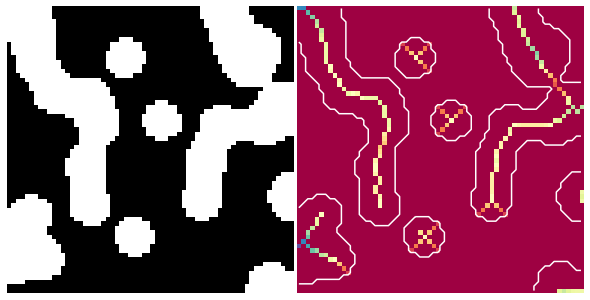

In [0]:
# via https://scikit-image.org/docs/0.9.x/auto_examples/plot_medial_transform.html
import numpy as np
from scipy import ndimage
from skimage.morphology import medial_axis
import matplotlib.pyplot as plt


def microstructure(l=256):
    """
    Synthetic binary data: binary microstructure with blobs.

    Parameters
    ----------

    l: int, optional
        linear size of the returned image

    """
    n = 5
    x, y = np.ogrid[0:l, 0:l]
    mask_outer = (x - l/2)**2 + (y - l/2)**2 < (l/2)**2
    mask = np.zeros((l, l))
    generator = np.random.RandomState(1)
    points = l * generator.rand(2, n**2)
    mask[(points[0]).astype(np.int), (points[1]).astype(np.int)] = 1
    mask = ndimage.gaussian_filter(mask, sigma=l/(4.*n))
    return mask > mask.mean()

data = microstructure(l=64)

# Compute the medial axis (skeleton) and the distance transform
skel, distance = medial_axis(data, return_distance=True)

# Distance to the background for pixels of the skeleton
dist_on_skel = distance * skel

plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.imshow(data, cmap=plt.cm.gray, interpolation='nearest')
plt.axis('off')
plt.subplot(122)
plt.imshow(dist_on_skel, cmap=plt.cm.get_cmap("Spectral"), interpolation='nearest')
plt.contour(data, [0.5], colors='w')
plt.axis('off')

plt.subplots_adjust(hspace=0.01, wspace=0.01, top=1, bottom=0, left=0, right=1)
plt.show()

### 3D skeletonization

Of course, an end-to-end 3D model is a natural goal. But as of yet there is no known [not that the author is aware of] one-step machine where imaged volumes go in and skeletons come out.

Therefore, existing 3D mask-to-skeleton algorithms will most likely come into play, at least in training feedback if not in the network itself. TEASAR seems to be one to try:
- [TEASAR](http://spin2013.cs.sunysb.edu/~bender/pub/PG2000_teasar.pdf)
  - seung-lab: [Python TEASAR Skeletonization for Sparse Labels](https://github.com/seung-lab/skeletonization)
  - [TEASAR: simple alg](https://github.com/scikit-image/scikit-image/issues/1621), MIT license
  - [Skeletonize.cpp](https://github.com/funkey/imageprocessing/blob/master/Skeletonize.cpp) funkey's C++, MIT


## Evaluation metrics

Algorithm performance must be scored via some objective evaluation metric. Usually this boils down to juxtaposing a generated skeleton against a ground truth skeleton, evaluated via some metric. Surprisingly the skeletons are usually not what the models generate – they generate masks which then get skeletonized (but such is the state of the art, until there exists some end-to-end image-stack-to-swc machine).


### The DIADEM Metric

[The DIADEM Metric](http://diademchallenge.org/metric.html) is described in the paper, [The DIADEM Data Sets: Representative Light Microscopy Images of Neuronal Morphology to Advance Automation of Digital Reconstructions](https://www.researchgate.net/publication/49769275_The_DIADEM_Data_Sets_Representative_Light_Microscopy_Images_of_Neuronal_Morphology_to_Advance_Automation_of_Digital_Reconstructions) (Brown et al 2011).

**Abstract:**
>The comprehensive characterization of neuronal morphology requires tracing extensive axonal and dendritic arbors imaged with light microscopy into digital reconstructions. Considerable effort is ongoing to automate this greatly labor-intensive and currently rate-determining process. Experimental data in the form of manually traced digital reconstructions and corresponding image stacks play a vital role in developing increasingly more powerful reconstruction algorithms. The DIADEM challenge (short for DIgital reconstruction of Axonal and DEndritic Morphology) successfully stimulated progress in this area by utilizing six data set collections from different animal species, brain regions, neuron types, and visualization methods. The original research projects that provided these data are representative of the diverse scientific questions addressed in this field. At the same time, these data provide a benchmark for the types of demands automated software must meet to achieve the quality of manual reconstructions while minimizing human involvement. The DIADEM data underwent extensive curation, including quality control, metadata annotation, and format standardization, to focus the challenge on the most substantial technical obstacles. This data set package is now freely released ( http://diademchallenge.org ) to train, test, and aid development of automated reconstruction algorithms.


[The DIADEM Metric README](http://diademchallenge.org/metric_readme.html):
>The DIADEM metric is implemented as a command line Java program run from a JAR file that is downloadable from this site. This requires that you have Java installed on your computer. Java is available at http://www.java.com/ where you will be directed to the appropriate version for your operating system. The metric can score one gold standard reconstruction against one test reconstruction, or several of each at one time, depending on the values of the first two parameters. Expected units in the SWC files are pixels for X and Y, and images for Z (the same units as those in the provided manual reconstructions). The downloadable file, DiademMetric.zip (version 2.1 release notes) contains the following files…

Colab comes with a JVM pre-configured.

In [1]:
!java --version

openjdk 11.0.6 2020-01-14
OpenJDK Runtime Environment (build 11.0.6+10-post-Ubuntu-1ubuntu118.04.1)
OpenJDK 64-Bit Server VM (build 11.0.6+10-post-Ubuntu-1ubuntu118.04.1, mixed mode, sharing)



### Expected Run Lenght (ERL)
[Google Connectomics](https://research.google/teams/perception/connectomics/) uses the "expected run length" (ERL) as a metric.

<img src="https://1.bp.blogspot.com/-x7pyYbuScFo/WzQa1TbrpwI/AAAAAAAADGc/XKOLMuoKqOkZNyU3pb84qiXn_zQh8VSkgCLcBGAs/s1600/image2.png" width="70%" />


On page 26, see the section entitled, "Skeleton​​ edge ​​accuracy​​ classification.":
> Working with our partners at the Max Planck Institute, we devised a metric we call **“expected run length” (ERL)** that measures the following: given a random point within a random neuron in a 3d image of a brain, how far can we trace the neuron before making some kind of mistake? This is an example of a **mean-time-between-failure metric**, except that in this case we measure the amount of space between failures rather than the amount of time. For engineers, the appeal of ERL is that it relates a linear, physical path length to the frequency of individual mistakes that are made by an algorithm, and that it can be computed in a straightforward way. 

> In contrast to prior approaches, the ERL takes into account the spatial distribution of errors.
Previously proposed metrics, such as the total error-free path length (TEFPL) 11,32 and inter-error
distance (IED) 11 are defined as simple averages and are thus insensitive to the distribution of
lengths of the correctly reconstructed fragments (see Sup. Fig. 2 for an illustration). 



## References

Other skeletonization methods:
- [DeepNeuron: An Open Deep Learning Toolbox for Neuron Tracing](https://www.biorxiv.org/content/10.1101/254318v1.full.pdf)
  - Vaa3D, Allen Institute 2018
